In [4]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split
import torch
from torch import nn
from sklearn.metrics import accuracy_score
import numpy as np
from torch.utils.data import Dataset, DataLoader

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [7]:
n_samples = 1000

X, y = make_circles(n_samples=1000,
    noise=0.03,
    random_state=42,
)


1. visualize data
2. convert data to tensor(float32), train-test split
3. build model
4. loss function
5. optimizer
6. Training and testing loop

In [8]:
X.shape, y.shape

((1000, 2), (1000,))

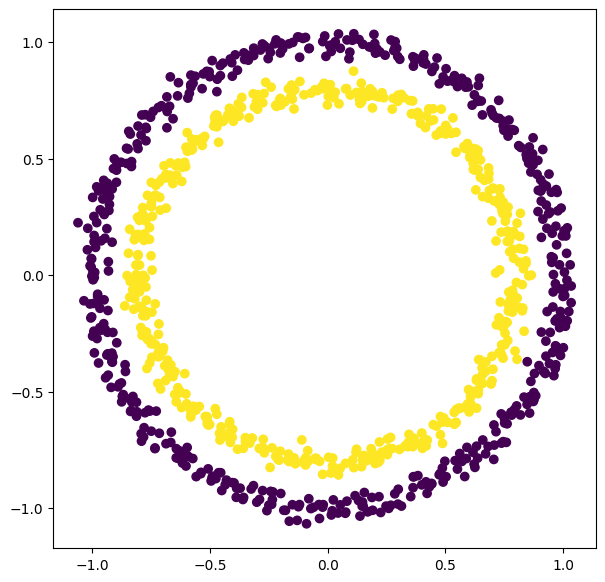

In [9]:
plt.figure(figsize=(7,7))
plt.scatter(X[:,0], X[:,1], c=y)

In [10]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)
X_train.to(device)
X_test.to(device)
y_test.to(device)
y_train.to(device)

tensor([1., 0., 0., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0.,
        0., 1., 1., 1., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1.,
        1., 1., 0., 1., 1., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 1.,
        1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 1., 0., 1., 0., 1.,
        1., 1., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 0., 1., 1., 0., 0., 1., 0., 1., 1., 0., 1., 0., 1., 0., 1., 0., 1.,
        0., 0., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 0., 1.,
        1., 0., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 0., 0., 1., 1., 0.,
        0., 1., 1., 1., 1., 0., 1., 1., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1.,
        0., 1., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 1.,
        1., 1., 0., 0., 0., 0., 1., 1., 0., 1., 1., 0., 0., 0., 1., 0., 1., 1.,
        1., 1., 1., 0., 1., 0., 0., 0., 

### Making custom dataset for batch

In [11]:
class CircleData(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, index):
        X = self.features[index]
        y = self.labels[index]

        return X, y

In [12]:
train_data = CircleData(X_train, y_train)
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)

test_data = CircleData(X_test, y_test)
test_loader = DataLoader(test_data, batch_size=32, shuffle=True)

In [123]:
class CircleModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(2, 8)
        self.layer2 = nn.Linear(8, 1)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x1 = self.layer1(x)
        x2 = self.relu(x1)
        x3 = self.layer2(x2)
        return x3

model = CircleModel().to(device)




##### Tried using tanh and sigmoid on playground.tensorflow.org, derivative of sigmoid is very small compared to tanh so weight updates are slow. increasing learning rate helps sigmoid. 
BCEwithlogitsloss means first sigmoid then binary cross etropy loss, used for better numerical stability.

In [124]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.3)
model.state_dict().items()

odict_items([('layer1.weight', tensor([[-0.2338, -0.0828],
        [ 0.2226,  0.3041],
        [ 0.4602,  0.0240],
        [-0.2909,  0.1642],
        [ 0.3806, -0.4057],
        [ 0.0703,  0.1920],
        [ 0.7020, -0.6887],
        [-0.1852,  0.5870]])), ('layer1.bias', tensor([-0.5132,  0.1490,  0.3283,  0.3106,  0.5162, -0.4479, -0.4401,  0.6807])), ('layer2.weight', tensor([[-0.0516, -0.3332, -0.2892,  0.0790,  0.0933,  0.1350, -0.1488, -0.2172]])), ('layer2.bias', tensor([-0.1789]))])

### Training loop

In [125]:
num_epochs = 2000

train_loss_values = []
test_loss_values = []
train_accuracy_values = []
test_accuracy_values = []
for epochs in range(num_epochs):
    # model.train()
    logits = model(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(logits))
    loss = loss_fn(logits, y_train)
    accuracy = accuracy_score(y_train, y_pred.detach().numpy())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    model.eval()
    with torch.inference_mode():
        test_logits = model(X_test).squeeze()
        y_pred_test = torch.round(torch.sigmoid(test_logits))
        test_loss = loss_fn(test_logits, y_test)
        test_accuracy = accuracy_score(y_test, y_pred_test.detach().numpy())
        train_accuracy_values.append(accuracy)
        test_accuracy_values.append(test_accuracy)
        train_loss_values.append(loss)
        test_loss_values.append(test_loss)
        if(epochs % 100 == 0):
            print(f"Epoch {epochs}: Train loss {loss}, Train accuracy {accuracy}, Test loss {test_loss}, Test accuracy {test_accuracy}")

Epoch 0: Train loss 0.7156113982200623, Train accuracy 0.5, Test loss 0.704018235206604, Test accuracy 0.5
Epoch 100: Train loss 0.6819660663604736, Train accuracy 0.55, Test loss 0.6815504431724548, Test accuracy 0.555
Epoch 200: Train loss 0.66990065574646, Train accuracy 0.64625, Test loss 0.6715290546417236, Test accuracy 0.66
Epoch 300: Train loss 0.6492259502410889, Train accuracy 0.6925, Test loss 0.655124306678772, Test accuracy 0.665
Epoch 400: Train loss 0.6153221726417542, Train accuracy 0.795, Test loss 0.6289449334144592, Test accuracy 0.735
Epoch 500: Train loss 0.5609937906265259, Train accuracy 0.865, Test loss 0.5865919589996338, Test accuracy 0.81
Epoch 600: Train loss 0.48570477962493896, Train accuracy 0.91, Test loss 0.5227800607681274, Test accuracy 0.845
Epoch 700: Train loss 0.3958693742752075, Train accuracy 0.95, Test loss 0.44297707080841064, Test accuracy 0.925
Epoch 800: Train loss 0.3095041513442993, Train accuracy 0.97875, Test loss 0.36907118558883667, T

In [126]:
def plot_decision_boundary(X, y, model, title="Decision Boundary", xlabel="Feature 1", ylabel="Feature 2"):
    model.eval()
    h = 0.02  
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    meshgrid_tensor = torch.FloatTensor(np.c_[xx.ravel(), yy.ravel()])

    with torch.no_grad():
        Z = model(meshgrid_tensor)
        Z = torch.sigmoid(Z).numpy().reshape(xx.shape) 

    plt.contourf(xx, yy, Z, cmap=plt.cm.RdBu, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdBu, edgecolors='k', marker='o')

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()


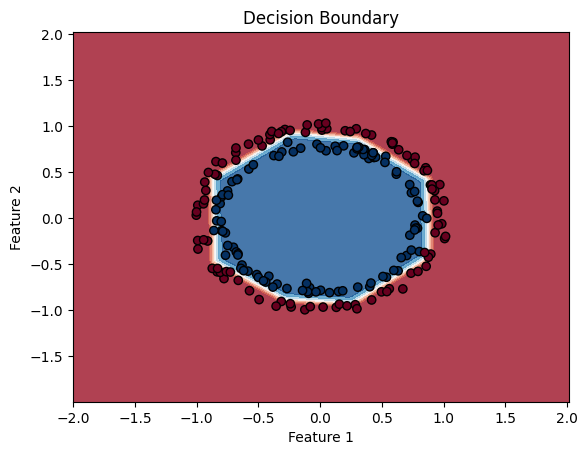

In [127]:
plot_decision_boundary(X_test,y_test, model)

In [45]:
import numpy as np 
import math
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
from torch import nn
from sklearn.metrics import accuracy_score
from torch.utils.data import DataLoader, Dataset

In [184]:
def spiral(radius, step, resolution=.1, angle=0.0, start=0.0):
    dist = start+0.0
    coords=[]
    while dist*math.hypot(math.cos(angle),math.sin(angle))<radius:
        cord=[]
        cord.append(dist*math.cos(angle))
        cord.append(dist*math.sin(angle))
        coords.append(cord)
        dist+=step
        angle+=resolution
    return np.array(coords)

In [185]:
torch.manual_seed(42)
X1 = spiral(10, 0.1)
X2 = spiral(10, 0.1, angle=math.pi)
X1 = np.insert(X1, X1.shape[1], 1, axis=1)
X2 = np.insert(X2, X2.shape[1], 0, axis=1)

X1.shape, X2.shape

((101, 3), (101, 3))

In [186]:
data = np.vstack([X1, X2])
data.shape

(202, 3)

In [187]:
data = torch.from_numpy(data).type(torch.float)
X_train, X_test, y_train, y_test = train_test_split(data[:, :2], data[:, 2:3], test_size=0.2, random_state=42)

In [188]:
X_train[0]

tensor([9.1182, 3.5915])

### Creating custom dataset for batch

In [189]:
class SpiralData(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels
        # print(self.features[0], self.labels[0])

    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, index):
        # print(self.features[index], self.labels[index])
        return self.features[index], self.labels[index]

In [190]:
train_data = SpiralData(X_train, y_train)
test_data = SpiralData(X_test, y_test)

In [191]:
train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
test_loader = DataLoader(test_data, batch_size=16)

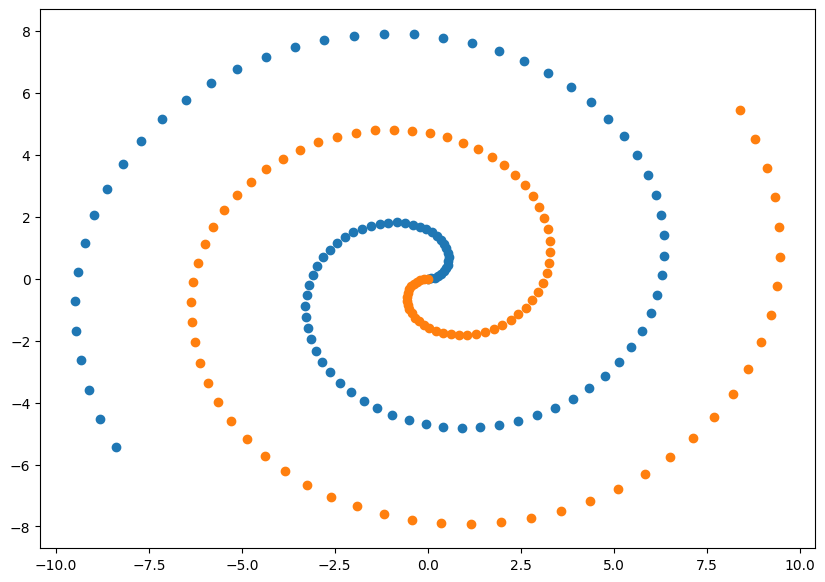

In [192]:
plt.figure(figsize=(10,7))
plt.scatter(X1[:, 0], X1[:,1])
plt.scatter(X2[:, 0], X2[:,1])
plt.show()

In [193]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

1. Visualize data
2. Convert to tensor(float32), send to device
3. train test split
4. Build model
5. loss function and optimizer
6. Training loop and testing loop

In [194]:
class SpiralModel(nn.Module):
    def __init__(self):
        super().__init__()

        self.layer_stack = nn.Sequential(
            nn.Linear(2, 8),
            nn.ReLU(),
            nn.Linear(8, 8),
            nn.ReLU(),
            nn.Linear(8, 8),
            nn.ReLU(),
            nn.Linear(8, 8),
            nn.ReLU(),
            nn.Linear(8, 1),
            nn.Sigmoid()
        )
        
        # self.layer1 = nn.Linear(2, 8)
        # self.layer2 = nn.Linear(8, 6)
        # self.layer3 = nn.Linear(6, 4)
        # self.layer4 = nn.Linear(4, 1)
        # self.relu = nn.ReLU()
        # self.sig = nn.Sigmoid()

    def forward(self, x):

        # x1 = self.layer1(x)
        # x2 = self.relu(x1)
        # x3 = self.layer2(x2)
        # x4 = self.relu(x3)
        # x5 = self.layer3(x4)
        # x6 = self.relu(x5)
        # x7 = self.layer4(x6)
        # x8 = self.sig(x7)

        return self.layer_stack(x)

model = SpiralModel().to(device)



In [195]:
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)

### Training loop

In [196]:
num_epochs = 500
test_accuracy_values = []
train_accuracy_values = []

torch.manual_seed(42)
for epochs in range(num_epochs):
    train_accuracy_cum = 0
    test_accuracy_cum = 0
    
    for batch in train_loader:
        
        model.train()
        X , y = batch
        X = X.to(device)
        y = y.to(device)
        train_logits = model(X)
        # print(train_logits.shape, y.shape)
        train_loss = loss_fn(train_logits, y)
        train_y_pred = torch.round(train_logits)
        train_accuracy = accuracy_score(y, train_y_pred.detach().numpy())
        train_accuracy_cum += train_accuracy
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        model.eval()
    
    avg_train_accuracy = train_accuracy_cum/len(train_loader)

    with torch.inference_mode():
        for batch in test_loader:
            X, y = batch
            X = X.to(device)
            y = y.to(device)
            test_logits = model(X)
            test_loss = loss_fn(test_logits, y)
            test_y_pred = torch.round(test_logits)
            test_accuracy = accuracy_score(y, test_y_pred.detach().numpy())
            test_accuracy_cum += test_accuracy
            
    avg_test_accuracy = test_accuracy_cum/len(test_loader)
    test_accuracy_values.append(avg_test_accuracy)
    train_accuracy_values.append(avg_train_accuracy)
    if((epochs+1) % 10 == 0):
        print(f"Epoch {epochs+1} : Train accuracy {avg_train_accuracy} | Test accuracy {avg_test_accuracy}")

Epoch 10 : Train accuracy 0.6022727272727273 | Test accuracy 0.5601851851851852
Epoch 20 : Train accuracy 0.7443181818181818 | Test accuracy 0.4861111111111111
Epoch 30 : Train accuracy 0.8011363636363636 | Test accuracy 0.5648148148148148
Epoch 40 : Train accuracy 0.8522727272727273 | Test accuracy 0.5856481481481481
Epoch 50 : Train accuracy 0.8636363636363636 | Test accuracy 0.5648148148148148
Epoch 60 : Train accuracy 0.7102272727272727 | Test accuracy 0.7592592592592592
Epoch 70 : Train accuracy 0.8920454545454546 | Test accuracy 0.6597222222222222
Epoch 80 : Train accuracy 0.8977272727272727 | Test accuracy 0.8796296296296297
Epoch 90 : Train accuracy 0.8977272727272727 | Test accuracy 0.8217592592592592
Epoch 100 : Train accuracy 0.9034090909090909 | Test accuracy 0.8217592592592592
Epoch 110 : Train accuracy 0.8977272727272727 | Test accuracy 0.8958333333333334
Epoch 120 : Train accuracy 0.9034090909090909 | Test accuracy 0.8217592592592592
Epoch 130 : Train accuracy 0.89204545

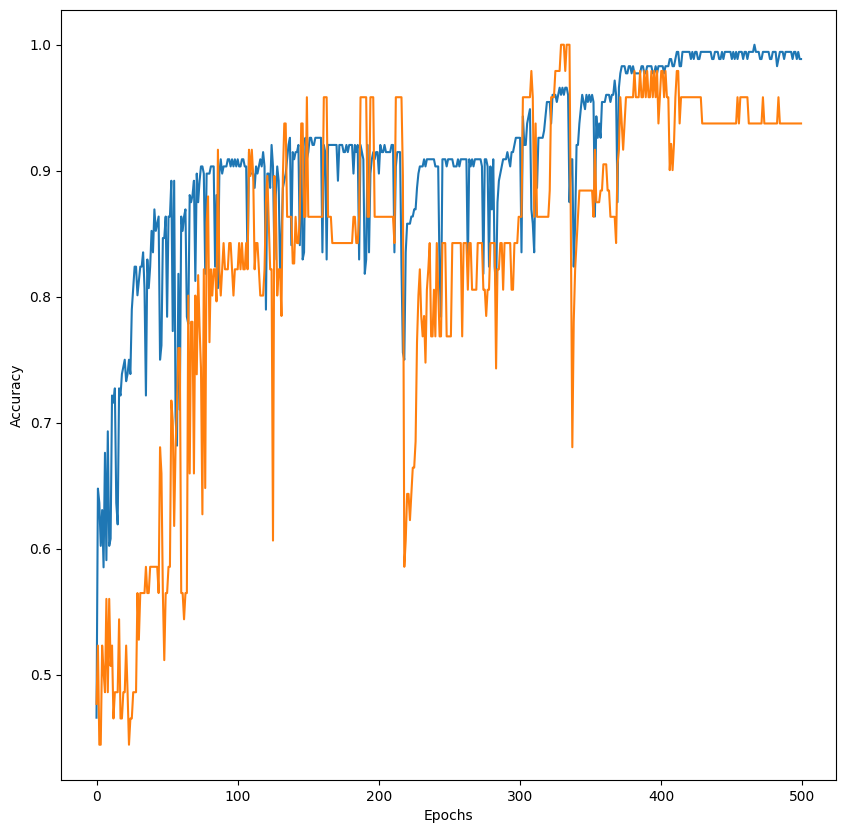

In [200]:
plt.figure(figsize=(10,10))
plt.plot(train_accuracy_values, label="Train Accuracy")
plt.plot(test_accuracy_values, label="Test Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()

In [201]:
def plot_decision_boundary(X, y, model, title="Decision Boundary", xlabel="Feature 1", ylabel="Feature 2"):
    model.eval()
    h = 0.02  
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    meshgrid_tensor = torch.FloatTensor(np.c_[xx.ravel(), yy.ravel()])

    with torch.no_grad():
        Z = model(meshgrid_tensor)
        Z = torch.sigmoid(Z).numpy().reshape(xx.shape) 

    plt.contourf(xx, yy, Z, cmap=plt.cm.RdBu, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdBu, edgecolors='k', marker='o')

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()


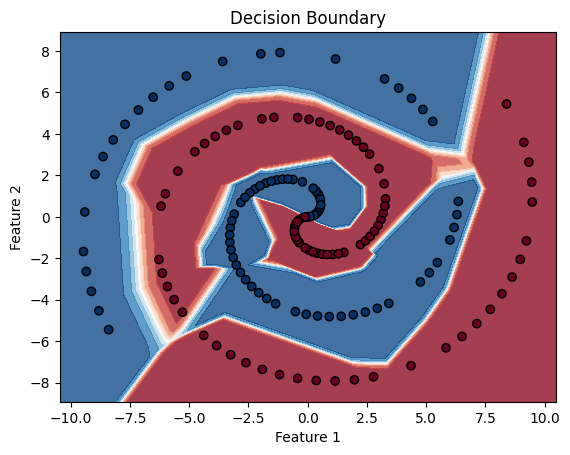

In [203]:
plot_decision_boundary(X_train,y_train,model)